In [1]:
# probability of firing analysis 

include("utilities.jl");
default(show=false)
default(fontfamily="Computer Modern")

In [3]:
labels = ["HC_CTRL", "LR_CTRL", "NR_CTRL", "HC_LITM", "LR_LITM", "NR_LITM"]
psc = Dict("HC_CTRL"=>[], "LR_CTRL"=>[], "NR_CTRL"=>[], "HC_LITM"=>[], "LR_LITM"=>[], "NR_LITM"=>[])


function load_spike_files(
    patterns::Union{UnitRange{Int64}, Vector{Int64}}, 
    model_label::String,
    neuron_ids::Dict;
    neurons_per_pattern::Int64=6, #
    data_dir::String="data/dgnetwork/")

    df = DataFrame()
    for p ∈ patterns
        spike_fname = data_dir*"DGsp-"*string(p)*"-"*string(neurons_per_pattern)*"-"*model_label*".txt"
        stims_fname = data_dir*"StimIn-"*string(p)*"-"*string(neurons_per_pattern)*"-"*model_label*".txt"
        spont_fname = data_dir*"NoiseStimIn-"*string(p)*"-"*string(neurons_per_pattern)*"-"*model_label*".txt"
        spikes = CSV.read(spike_fname, delim="\t", header=0, DataFrame)
        stimin = CSV.read(stims_fname, delim="\t", header=0, DataFrame)
        spont = CSV.read(spont_fname, delim="\t", header=0, DataFrame)

        if size(spikes, 1) > 0
            rename!(spikes, ["Time", "Neuron"])
            spikes[:,"Population"] .= "DG" 
            spikes[:,"Pattern"] .= p
            spikes[:,"NeuronsPerPattern"] .= neurons_per_pattern 
            spikes[:,"Model"] .= model_label
            for k ∈ keys(neuron_ids) 
                lb, ub = neuron_ids[k]
                spikes[lb .<= spikes[:, "Neuron"] .< ub, "Population"] .= k
            end

            df = [df; spikes]
        end 

        if size(stimin, 1) > 0
            rename!(stimin, ["Time", "Neuron"])
            stimin[:,"Population"] .= "PP"
            stimin[:,"Pattern"] .= p
            stimin[:,"NeuronsPerPattern"] .= neurons_per_pattern 
            stimin[:,"Model"] .= model_label
            df = [df; stimin]
        end

        if size(spont, 1) > 0
            rename!(spont, ["Time", "Neuron"])
            spont[:,"Population"] .= "Spont"
            spont[:,"Pattern"] .= p
            spont[:,"NeuronsPerPattern"] .= neurons_per_pattern 
            spont[:,"Model"] .= model_label
            df = [df; spont]
        end
    end

    return df
end


function load_connectivity_file( 
    model_label::String,
    run_number::Int64,
    neurons_per_pattern::Int64=6, 
    patterns::Int64=0,
    data_dir::String="data/dgnetwork/")

    connectivityfile = data_dir*"DGNC-"*string(patterns)*"-"*string(neurons_per_pattern)*"-"*model_label*"-"*string(run_number)*".txt"
    dgnc = CSV.read(connectivityfile, delim="\t", header=0, DataFrame)
    rename!(dgnc, ["neuronA", "neuronB"])
    return dgnc
end

function isolate_gclamellae(
    connectivityfile::DataFrame,
    lamellanumber::Int64, #lamella number, from 0-5
    )

    basketcellnumb = "BasketCell["*string(lamellanumber)*"]"
    lam1 = connectivityfile[findall(in([basketcellnumb]), connectivityfile.neuronA), :]
    gcl1 = lam1[[occursin(r"GranuleCell", s) for s in lam1[!, :neuronB]], :]

    gc_save = OrderedDict("Lamella1"=>[])
        for i ∈ 1:length(gcl1[!, :neuronB])
        gcstring = lam1[i, :neuronB]
        gcindex = gcstring[13:end-1]
        gcnumb = parse(Int64, gcindex)
        append!(gc_save["Lamella1"], gcnumb)
    end
    return gc_save
end


isolate_gclamellae (generic function with 1 method)

In [4]:
populations = Dict(
    "DG" => [0, 500],
    "BC" => [500,506],
    "MC" => [506, 521],
    "HIPP" => [521, 527]
)


Dict{String, Vector{Int64}} with 4 entries:
  "DG"   => [0, 500]
  "MC"   => [506, 521]
  "BC"   => [500, 506]
  "HIPP" => [521, 527]

In [5]:
# FUNCTIONS

function makechunks(convolution::Vector, n_neurons::Integer)
    chunks = length(convolution) ÷ n_neurons
    return [convolution[1+chunks*k:(k == n_neurons-1 ? end : chunks*k+chunks)] for k = 0:n_neurons-1]
end  

function compute_aggregate_WTA(
    spike_train::DataFrame, 
    n_neurons::Int64;
    delta::Int64=3, 
    n_bins::Int64=1,        
    duration::Float64=10.0)
    
    # Create kernel
    tri_rng = collect(1:round(Int64, delta/n_bins))
    triangular_kernel = [tri_rng; reverse(tri_rng)[2:end]]'

    # Create bins for histograms 
    bins = collect(1:n_bins:(duration + n_bins))

    convolved_series = zeros(round(Int64, n_neurons * duration / n_bins)) 
    for i ∈ 1:n_neurons
        s = spike_train[spike_train.Neuron .== (i-1), "Time"]
        timeseries, _ = np.histogram(s, bins)
        idx_low = round(Int64, (i-1)*duration/n_bins + 1)
        idx_high = round(Int64, i*duration/n_bins)
        convolved_series[idx_low:idx_high] = np.convolve(timeseries, triangular_kernel, "same")     #TODO: consider scipy.signal.fftconvolve as alt.
    end
    LFP = makechunks(convolved_series, n_neurons)
    return sum(LFP)
end

compute_aggregate_WTA (generic function with 1 method)

In [6]:
hcctrl_m = OrderedDict(0=>[], 1=>[], 2=>[], 3=>[], 4=>[], 5=>[])
hcctrl_se = OrderedDict(0=>[], 1=>[], 2=>[], 3=>[], 4=>[], 5=>[])
hclitm_m = OrderedDict(0=>[], 1=>[], 2=>[], 3=>[], 4=>[], 5=>[])
hclitm_se = OrderedDict(0=>[], 1=>[], 2=>[], 3=>[], 4=>[], 5=>[])

#n_patterns = 0:24
n_patterns=0:24
lamellae = 3:3
runs = 1:14  #actual 14
n_runs = length(runs)
conditions = ["HC_CTRL", "HC_LITM"]


hccrm_sv = []
hccac_sv = []
hclrm_sv = []
hclac_sv = []

spont_hcc = DataFrame()
spont_hcl = DataFrame()

for run ∈ runs
    df = []
    df2 = []
    hcc_rm = []
    hcl_rm = []
    hcc_ac = []
    hcl_ac = []

    println(run)
    
    for condition ∈ conditions

        for pattern ∈ n_patterns
            for lamella ∈ lamellae 

                neuronnumb = 500 + lamella
                confile = load_connectivity_file(condition, run)
                gc_save = isolate_gclamellae(confile, lamella)

                duration = 200
                spikes = load_spike_files(n_patterns, condition*"-"*string(run), populations)

                gcspikes = spikes[(spikes.Population .== "DG") .& (spikes.Pattern .== pattern), :]
                spont = spikes[(spikes.Population .== "Spont")  .& (spikes.Pattern .== pattern), :]

                lam1spikes = gcspikes[findall(in(gc_save["Lamella1"]), gcspikes.Neuron), :]
                lam1spont = spont[findall(in(gc_save["Lamella1"]), spont.Neuron), :]
                sponts = sort!(lam1spont)

                bc_0 = spikes[(spikes.Population .== "BC") .&(spikes.Neuron .== neuronnumb) .&(spikes.Pattern .== pattern), :]

                # TODO: 
                #  -- [X] Isolate the GC activated by spontaneous spike 
                #  -- [X] Isolate the remaining GCs 
                #  -- [] write code that computes activity level per unit time (will have to be average across SA instances to begin with) 

                # Isolate GC activated by spontaneous spike 
                gcsspont = lam1spont.Neuron
                lam1spike_postsa = lam1spikes[findall(in(gcsspont), lam1spikes.Neuron), :]

                lam1spike_remain = lam1spikes
                for x ∈ 1:length(gcsspont)
                    lam1spike_remain = lam1spike_remain[(lam1spike_remain.Neuron .!= gcsspont[x]), :]
                end
                
                # remaining GC spikes post spontaneous activation (not directly attached to GC getting activated)
                for spont in 1:length(sponts.Neuron)
                    
                    starttime = lam1spont[spont,"Time"]
                    timelimit = lam1spont[spont,"Time"] + 10

                    spikeinlim = lam1spike_remain
                    postspike = lam1spike_postsa

                    for x in 1:length(lam1spike_postsa[:,"Time"])
                        if  lam1spike_postsa[x, "Time"] .> starttime && lam1spike_postsa[x, "Time"] .<= timelimit
                            #println(lam1spike_remain[x, :])
                            timepost = lam1spike_postsa[x, "Time"] - starttime
                            postspike[x,"Time"] = timepost

                            #df2 = [df2; [Vector(postspike[x, :])]]
                            append!(df2,[Vector(postspike[x, :])])
                        end
                    end


                    for x in 1:length(lam1spike_remain[:,"Time"])
                        if  lam1spike_remain[x, "Time"] .> starttime && lam1spike_remain[x, "Time"] .<= timelimit
                            #println(lam1spike_remain[x, :])
                            timepost = lam1spike_remain[x, "Time"] - starttime
                            spikeinlim[x,"Time"] = timepost

                            #df = [df; [Vector(spikeinlim[x, :])]]
                            append!(df, [Vector(spikeinlim[x, :])])
                        end
                    end
                    #println(df)
                end
            #return sponts
            end
        end

        if condition == conditions[1]
            #print("hello")
            hcc_rm = stack(df, dims=1)
            #println(df)
            hcc_rm = DataFrame(hcc_rm, [:Time, :Neuron, :Population, :Pattern, :NeuronsPerPattern, :Model])
            hccrm = [compute_aggregate_WTA(hcc_rm, 500)]
            println(hccrm)
            hccrm_sv = append!(hccrm_sv, hccrm)
    
            hcc_ac = stack(df2, dims=1)
            hcc_ac = DataFrame(hcc_ac, [:Time, :Neuron, :Population, :Pattern, :NeuronsPerPattern, :Model])
            hccac = [compute_aggregate_WTA(hcc_ac, 500)]
            hccac_sv = append!(hccac_sv, hccac)
    
            #spont_hcc = sponts
        else
            #println("goodbye")
            hcl_rm = stack(df, dims=1)
            hcl_rm = DataFrame(hcl_rm, [:Time, :Neuron, :Population, :Pattern, :NeuronsPerPattern, :Model])
            hclrm = [compute_aggregate_WTA(hcl_rm, 500)]
            hclrm_sv = append!(hclrm_sv, hclrm)
    
            hcl_ac = stack(df2, dims=1)
            hcl_ac = DataFrame(hcl_ac, [:Time, :Neuron, :Population, :Pattern, :NeuronsPerPattern, :Model])
            hclac = [compute_aggregate_WTA(hcl_ac, 500)]
            hclac_sv = append!(hclac_sv, hclac)
    
            #spont_hcl = sponts
        end
        
    end

end

return hccrm_sv 
return hccac_sv

return hclrm_sv
return hclac_sv


1


[[111.0, 143.0, 125.0, 97.0, 83.0, 86.0, 97.0, 97.0, 93.0, 55.0]]


2


[[50.0, 84.0, 110.0, 119.0, 121.0, 108.0, 91.0, 60.0, 35.0, 13.0]]


3


[[22.0, 34.0, 42.0, 40.0, 31.0, 29.0, 35.0, 43.0, 33.0, 17.0]]


4


[[91.0, 101.0, 87.0, 65.0, 48.0, 43.0, 36.0, 30.0, 16.0, 6.0]]


5


[[50.0, 77.0, 95.0, 107.0, 99.0, 98.0, 100.0, 101.0, 75.0, 37.0]]


6


[[25.0, 27.0, 23.0, 18.0, 29.0, 62.0, 113.0, 142.0, 133.0, 75.0]]


7


[[30.0, 50.0, 70.0, 79.0, 75.0, 64.0, 59.0, 55.0, 45.0, 24.0]]


8


[[83.0, 110.0, 125.0, 134.0, 134.0, 128.0, 115.0, 96.0, 69.0, 34.0]]


9


[[75.0, 106.0, 116.0, 124.0, 121.0, 127.0, 128.0, 125.0, 103.0, 57.0]]


10


[[38.0, 43.0, 46.0, 46.0, 50.0, 66.0, 77.0, 83.0, 63.0, 34.0]]


11


[[77.0, 105.0, 105.0, 76.0, 55.0, 48.0, 54.0, 53.0, 44.0, 24.0]]


12


[[64.0, 86.0, 87.0, 72.0, 54.0, 45.0, 39.0, 36.0, 26.0, 14.0]]


13


[[35.0, 55.0, 75.0, 109.0, 144.0, 178.0, 183.0, 146.0, 91.0, 36.0]]


14


[[109.0, 145.0, 140.0, 112.0, 87.0, 74.0, 67.0, 51.0, 38.0, 18.0]]


14-element Vector{Any}:
 [485.0, 520.0, 353.0, 174.0, 74.0, 72.0, 72.0, 66.0, 46.0, 22.0]
 [530.0, 579.0, 403.0, 201.0, 87.0, 88.0, 101.0, 100.0, 76.0, 38.0]
 [465.0, 491.0, 332.0, 157.0, 73.0, 75.0, 80.0, 69.0, 53.0, 27.0]
 [499.0, 537.0, 360.0, 159.0, 49.0, 48.0, 54.0, 51.0, 35.0, 17.0]
 [446.0, 504.0, 342.0, 171.0, 57.0, 58.0, 66.0, 68.0, 52.0, 25.0]
 [542.0, 604.0, 406.0, 189.0, 60.0, 62.0, 78.0, 79.0, 66.0, 34.0]
 [457.0, 521.0, 369.0, 200.0, 87.0, 80.0, 73.0, 64.0, 39.0, 17.0]
 [555.0, 632.0, 436.0, 230.0, 99.0, 92.0, 75.0, 53.0, 30.0, 13.0]
 [535.0, 575.0, 403.0, 206.0, 108.0, 112.0, 112.0, 89.0, 58.0, 26.0]
 [471.0, 524.0, 355.0, 170.0, 56.0, 50.0, 53.0, 46.0, 33.0, 14.0]
 [519.0, 589.0, 428.0, 233.0, 103.0, 86.0, 85.0, 81.0, 64.0, 33.0]
 [464.0, 507.0, 359.0, 183.0, 80.0, 67.0, 67.0, 61.0, 44.0, 21.0]
 [491.0, 536.0, 365.0, 181.0, 67.0, 61.0, 60.0, 57.0, 46.0, 24.0]
 [463.0, 509.0, 352.0, 180.0, 85.0, 86.0, 83.0, 69.0, 48.0, 24.0]

In [601]:
spont_hcc[!, "Time"] == spont_hcl[!, "Time"] #solid

false

In [81]:
# transform those ugly dfs into something actually usable 
mean(hccac_sv)


10-element Vector{Float64}:
 290.07142857142856
 296.5
 198.21428571428572
  94.21428571428571
  45.214285714285715
  46.57142857142857
  47.642857142857146
  42.0
  30.071428571428573
  14.428571428571429

compute_aggregate_WTA (generic function with 1 method)

In [7]:
const PLOTS_DEFAULTS = Dict(
    :theme =>:default,
    :fontfamily => "DejaVu Sans",
    :scalefontsizes => 20
)

Dict{Symbol, Any} with 3 entries:
  :scalefontsizes => 20
  :theme          => :default
  :fontfamily     => "DejaVu Sans"

In [12]:


sumfig = plot(mean(hccrm_sv), yerror=(std(hccrm_sv)/sqrt(n_runs)), label = "CTRL", color = :black, msc=:black, linewidth = 3)
plot!(mean(hclrm_sv), yerror=(std(hclrm_sv)/sqrt(n_runs)), label = "LITM", color = :grey70, msc=:grey70,
    xlabel = "Time Post-SS (ms)",
    ylabel = "RM Population Activity", grid = false, size=(300, 300), dpi=300, fontfamily = "DejaVu Sans", linewidth = 3)

savefig(sumfig, "figures/wta/aggregate_timeseries_hc_rm_l3_cosyne.png")


"/Users/selenasingh/Desktop/spiketrainBDDG/wSA/figures/wta/aggregate_timeseries_hc_rm_l3_cosyne.png"

In [13]:

sumfig = plot(mean(hccac_sv), yerror=(std(hccac_sv)/sqrt(n_runs)), label = "CTRL", color = :black, msc=:black, linewidth = 3)
plot!(mean(hclac_sv), yerror=(std(hclac_sv)/sqrt(n_runs)), label = "LITM", color = :grey70, msc=:grey70,
    xlabel = "Time Post-SS (ms)",
    ylabel = "AC Population Activity", grid = false,  size=(300, 300), dpi=300, fontfamily = "DejaVu Sans", linewidth = 3)

savefig(sumfig, "figures/wta/aggregate_timeseries_hc_ac_l3_cosyne.png")


"/Users/selenasingh/Desktop/spiketrainBDDG/wSA/figures/wta/aggregate_timeseries_hc_ac_l3_cosyne.png"

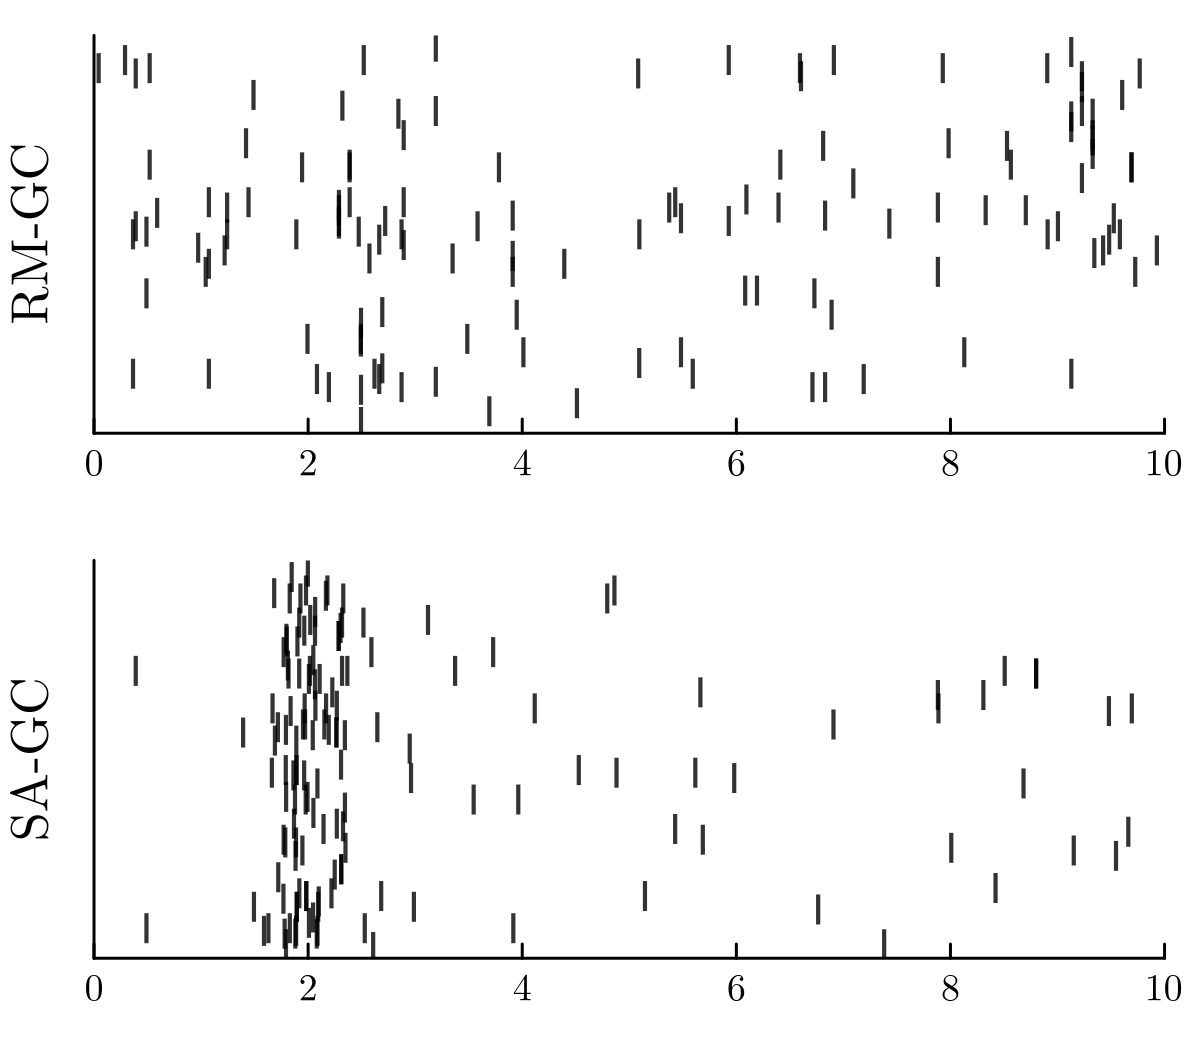

In [500]:

starttime = 1
timelimit = 10

plots = []

gs = scatter(hcc_ac[:, 1], hcc_ac[:,2], 
                marker = (:vline, 5, 0.8, :black, stroke(2, 0.8, :black, :vline)),
                label=nothing, c=:red, msc=:black, #msa=1, ma=1, 
                ylabel = "SA-GC",
                xlims = [(starttime-1),timelimit], grid = false, yticks=false )

gr = scatter(hcc_rm[:, 1], hcc_rm[:,2], 
                marker = (:vline, 5, 0.8, :black, stroke(2, 0.8, :black, :vline)),
                label=nothing, c=:red, msc=:black, #msa=1, ma=1, 
                ylabel = "RM-GC",
                xlims = [(starttime-1),timelimit], grid = false, yticks=false )


append!(plots, [gr])
append!(plots, [gs])

fig1 = plot(plots..., layout=grid(2, 1, 
            heights=[0.5, 0.5]), 
            size=(400, 350), dpi = 300)

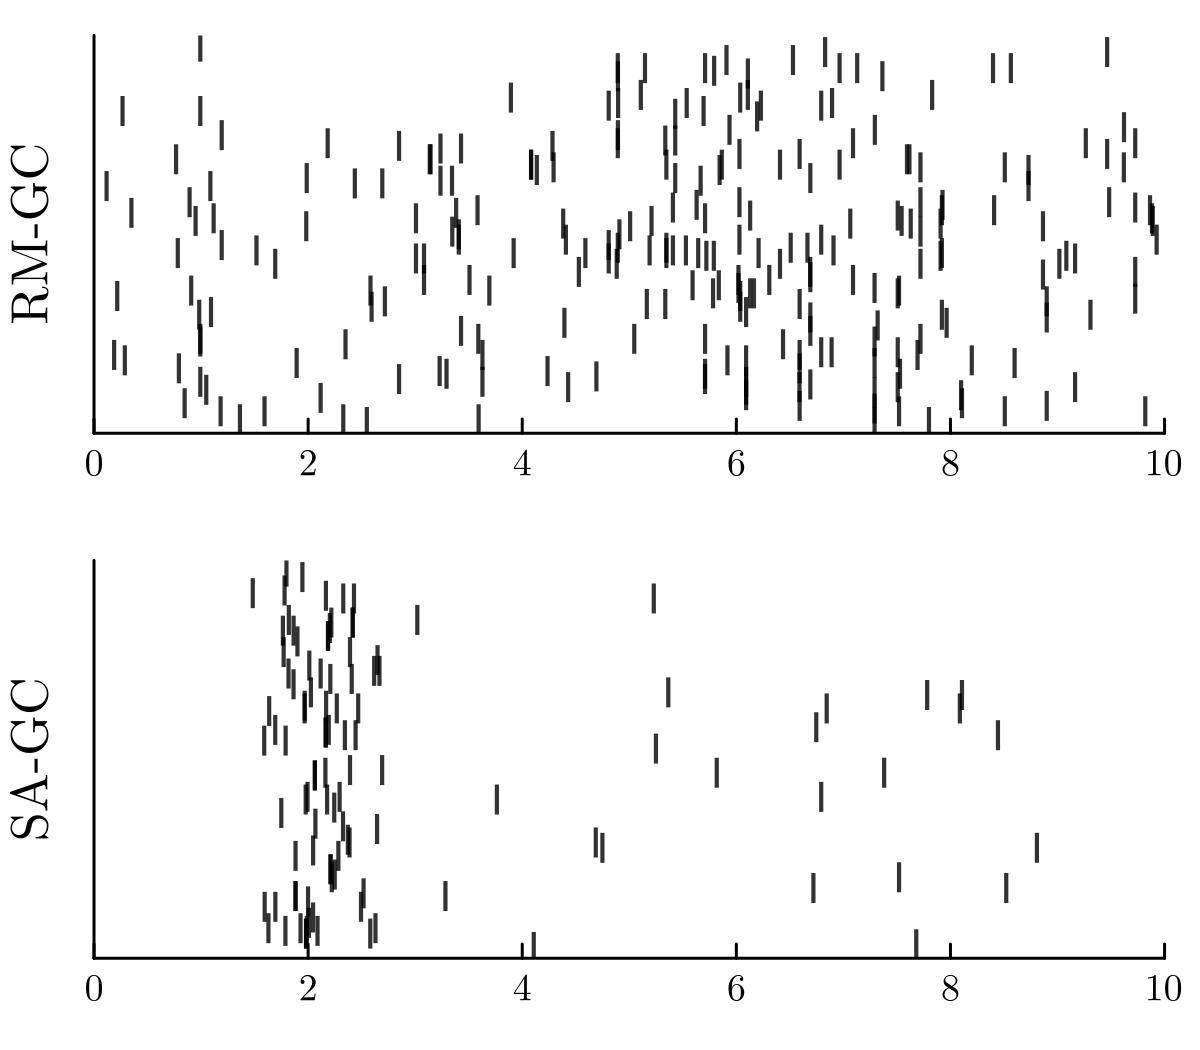

In [501]:

starttime = 1
timelimit = 10

plots = []
s = scatter(spont_hcl[:, "Time"], spont_hcl[:, "Neuron"], 
                marker = (:vline, 5, 0.8, :red, stroke(2, 0.8, :black, :vline)),
                label=nothing, c=:red, msc=:black, #msa=1, ma=1, 
                ylabel = "SA",
                xlims = [(starttime-1),timelimit], grid = false, yticks=false )

gs = scatter(hcl_ac[:, 1], hcl_ac[:,2], 
                marker = (:vline, 5, 0.8, :black, stroke(2, 0.8, :black, :vline)),
                label=nothing, c=:red, msc=:black, #msa=1, ma=1, 
                ylabel = "SA-GC",
                xlims = [(starttime-1),timelimit], grid = false, yticks=false )

gr = scatter(hcl_rm[:, 1], hcl_rm[:,2], 
                marker = (:vline, 5, 0.8, :black, stroke(2, 0.8, :black, :vline)),
                label=nothing, c=:red, msc=:black, #msa=1, ma=1, 
                ylabel = "RM-GC",
                xlims = [(starttime-1),timelimit], grid = false, yticks=false )

bc0 = scatter(bc_0[:, "Time"], bc_0[:, "Neuron"], 
                marker = (:vline, 5, 0.8, :blue, stroke(2, 0.8, :black, :vline)),
                    label=nothing, c=:red, msc=:black, #msa=1, ma=1, 
                    ylabel = "BC",
                    xlims = [(starttime-1),timelimit], grid = false, yticks=false )

append!(plots, [gr])
append!(plots, [gs])

fig1 = plot(plots..., layout=grid(2, 1, 
            heights=[0.5, 0.5]), 
            size=(400, 350), dpi = 300)